In [295]:
import torch

In [296]:
#assert torch.__version__.startswith('2.3') and 'cu121' in torch.__version__, "The Colab torch version has changed, you may need to edit the !pip install cell to install matching torch_geometric versions"

In [297]:
import warnings
warnings.filterwarnings('ignore')

In [298]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import rdkit
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import rdChemReactions
from rdkit.Chem import AllChem
from rdkit.Chem import Draw,BRICS,Recap
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdmolops
from rdkit.Chem.BRICS import BRICSDecompose
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import QED

from PIL import Image

import sys
import re
import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import sascorer

In [299]:
df = pd.read_excel('D:\drug_modelling\Oxazolidinone.xlsx')
df.drop([0],inplace = True)
df.drop({'Unnamed: 0'},axis = 1, inplace = True)
df.rename({'Unnamed: 3':'MIC'},inplace=True,axis = 1)
df.dropna(inplace = True)
df['REWARD'] = 1/df['MIC']
df['PMIC']=np.log(df['MIC'])
df['pic50']=6-np.log(df['MIC'])
df.reset_index(inplace = True,drop = True)
# df2.rename({'pMIC':'Reward'},axis = 1,inplace = True)

In [300]:
sorted(df['pic50'])

[1.147969736080383,
 1.147969736080383,
 1.147969736080383,
 1.147969736080383,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8256127301043632,
 1.8411169166403285,
 1.8411169166403285,
 1.8411169166403285,
 2.087976994571854,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 2.5342640972002735,
 3.227411277760219,
 3.227411277760219,
 3.227411277760219,
 3.697414907005954,
 3.9205584583201643,
 3.9205584583201643,
 3.9205584583201643,
 3.9205584583201643,
 3.9205584583201643,
 

In [301]:
def number_atoms(mol):
  mol2 = mol
  for i, atom in enumerate(mol2.GetAtoms()):
      # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
      atom.SetProp("molAtomMapNumber", str(atom.GetIdx()))

  return mol2

def AromaticAtoms(mol):
    aromatic_atoms = [mol.GetAtomWithIdx(i).GetIsAromatic() for i in range(mol.GetNumAtoms())]
    aa_count = []
    for i in aromatic_atoms:
      if i==True:
        aa_count.append(1)
    sum_aa_count = sum(aa_count)
    return sum_aa_count

def calc_descriptors(df):
  mols = [Chem.MolFromSmiles(smi) for smi in df['SMILE']]
  desc_MolLogP = [Descriptors.MolLogP(mol) for mol in mols]
  desc_MolWt = [Descriptors.MolWt(mol) for mol in mols]
  desc_NumRotatableBonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
  desc_AromaticAtoms = [AromaticAtoms(mol) for mol in mols]
  df['MolLogP'] = desc_MolLogP
  df['MolWt'] = desc_MolWt
  df['NumRotatableBonds'] = desc_NumRotatableBonds
  df['AromaticAtoms'] = desc_AromaticAtoms
  return df

#To test what samples are generated once before or after the training
def test_model(model = None,num_samples = 16, sub_img_size = 500,mols_per_row = 4):
  trajs = algo.create_training_data_from_own_samples(model,num_samples)
  gen_mols = []
  valid_trajs=[]
  for traj in trajs:
    try:
      mol = ctx.graph_to_obj(traj['result'])
      Chem.SanitizeMol(mol)  # Validate the molecule
      gen_mols.append(mol)
      valid_trajs.append(traj)
    except Chem.AtomValenceException:
      print(f"Valence issue in: {traj['result']}")
    except Chem.KekulizeException:
      print(f"Kekulization issue in: {traj['result']}")
    except Exception as e:
      print(f"Error: {e}")
  
  #gen_mols = [ctx.graph_to_obj(x['result']) for x in trajs]
  gen_mols_smiles = [Chem.MolToSmiles(mol) for mol in gen_mols]
  return gen_mols_smiles,gen_mols,Chem.Draw.MolsToGridImage(gen_mols, molsPerRow=mols_per_row, subImgSize=(sub_img_size, sub_img_size))

In [302]:
df = calc_descriptors(df)

In [303]:
display(df)

SMILE Compound    MIC  \
0    NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...       2a  10.00   
1    CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...       2b   1.00   
2    CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...       2c   1.00   
3    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2d   0.25   
4    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2e   0.25   
..                                                 ...      ...    ...   
228  S=C(NC1=CC=C(F)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53d  65.00   
229  S=C(NC1=CC=C(I)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53e  65.00   
230  S=C(NC1=CC=C(OC)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)...      53f  50.00   
231  S=C(NC1=CC=C(C)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53g  65.00   
232  S=C(NC1=CC=C([N+]([O-])=O)C=C1)NC2=CC=C(C[C@]3...      53h  65.00   

       REWARD      PMIC     pic50  MolLogP    MolWt  NumRotatableBonds  \
0    0.100000  2.302585  3.697415  0.75880  458.498                  6   
1    1.000000  0.000000  6.000000  1.50812  502.507                  8   
2    1.000000  0.000000  6.000000  1.89822  516.534                  8   
3    4.000000 -1.386294  7.386294  1.94430  474.449                  7   
4    4.000000 -1.386294  7.386294  2.41280  490.517                  7   
..        ...       ...       ...      ...      ...                ...   
228  0.015385  4.174387  1.825613  3.67560  359.426                  4   
229  0.015385  4.174387  1.825613  4.14110  467.332                  4   
230  0.020000  3.912023  2.087977  3.54510  371.462                  5   
231  0.015385  4.174387  1.825613  3.84492  355.463                  4   
232  0.015385  4.174387  1.825613  3.44470  386.433                  5   

     AromaticAtoms  
0               11  
1               11  
2               11  
3               11  
4               11  
..             ...  
228             12  
229             12  
230             12  
231             12  
232             12  

[233 rows x 10 columns]

In [304]:
def compute_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * 11  

    mol_weight = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    num_h_donors = Lipinski.NumHDonors(mol)
    num_h_acceptors = Lipinski.NumHAcceptors(mol)
    
    
    return [mol_weight, logp, tpsa, num_h_donors, num_h_acceptors]


df[['Molecular_Weight', 'LogP', 'TPSA', 'Num_H_Donors', 'Num_H_Acceptors']] = df['SMILE'].apply(compute_properties).apply(pd.Series)

In [305]:
display(df)

SMILE Compound    MIC  \
0    NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...       2a  10.00   
1    CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...       2b   1.00   
2    CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...       2c   1.00   
3    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2d   0.25   
4    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2e   0.25   
..                                                 ...      ...    ...   
228  S=C(NC1=CC=C(F)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53d  65.00   
229  S=C(NC1=CC=C(I)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53e  65.00   
230  S=C(NC1=CC=C(OC)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)...      53f  50.00   
231  S=C(NC1=CC=C(C)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53g  65.00   
232  S=C(NC1=CC=C([N+]([O-])=O)C=C1)NC2=CC=C(C[C@]3...      53h  65.00   

       REWARD      PMIC     pic50  MolLogP    MolWt  NumRotatableBonds  \
0    0.100000  2.302585  3.697415  0.75880  458.498                  6   
1    1.000000  0.000000  6.000000  1.50812  502.507                  8   
2    1.000000  0.000000  6.000000  1.89822  516.534                  8   
3    4.000000 -1.386294  7.386294  1.94430  474.449                  7   
4    4.000000 -1.386294  7.386294  2.41280  490.517                  7   
..        ...       ...       ...      ...      ...                ...   
228  0.015385  4.174387  1.825613  3.67560  359.426                  4   
229  0.015385  4.174387  1.825613  4.14110  467.332                  4   
230  0.020000  3.912023  2.087977  3.54510  371.462                  5   
231  0.015385  4.174387  1.825613  3.84492  355.463                  4   
232  0.015385  4.174387  1.825613  3.44470  386.433                  5   

     AromaticAtoms  Molecular_Weight     LogP    TPSA  Num_H_Donors  \
0               11           458.498  0.75880  121.32           2.0   
1               11           502.507  1.50812  138.44           1.0   
2               11           516.534  1.89822  138.44           1.0   
3               11           474.449  1.94430  133.76           1.0   
4               11           490.517  2.41280  120.62           1.0   
..             ...               ...      ...     ...           ...   
228             12           359.426  3.67560   62.39           3.0   
229             12           467.332  4.14110   62.39           3.0   
230             12           371.462  3.54510   71.62           3.0   
231             12           355.463  3.84492   62.39           3.0   
232             12           386.433  3.44470  105.53           3.0   

     Num_H_Acceptors  
0                9.0  
1               10.0  
2               10.0  
3                9.0  
4                9.0  
..               ...  
228              3.0  
229              3.0  
230              4.0  
231              3.0  
232              5.0  

[233 rows x 15 columns]

testing models for proper mic prediction. 


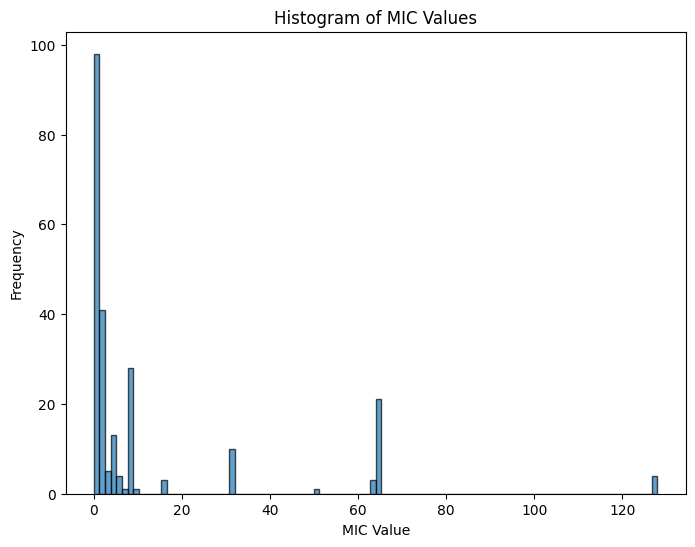

In [306]:
plt.figure(figsize=(8, 6)) 
plt.hist(df['MIC'], bins=100, edgecolor='black', alpha=0.7)

plt.xlabel('MIC Value')
plt.ylabel('Frequency')
plt.title('Histogram of MIC Values')

plt.show()

In [307]:
from rdkit import Chem
from rdkit.Chem import SaltRemover
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import Chem, RDLogger

# Disable RDKit error and warning messages
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
def standardize_smiles(smiles):
    # Remove salts and neutralize charges
    remover = SaltRemover.SaltRemover()
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None
    
    clean_mol = remover.StripMol(mol)
    # Use the correct function name from rdMolStandardize
    clean_mol = rdMolStandardize.ChargeParent(clean_mol)
    
    # Standardize tautomers
    enumerator = rdMolStandardize.TautomerEnumerator()
    return enumerator.Canonicalize(clean_mol)

# Assuming df contains a column 'SMILE'
df['standard_smiles'] = df['SMILE'].apply(standardize_smiles)
df = df.dropna(subset=['standard_smiles'])
display(df)

SMILE Compound    MIC  \
0    NC1=CN=C(C=NN2CCN(C3=CC=C(N4C[C@H](CNC(C)=O)OC...       2a  10.00   
1    CC1=NC=C([N+]([O-])=O)N1CC=NN2CCN(C3=CC=C(N4C[...       2b   1.00   
2    CC1=NC=C([N+]([O-])=O)N1CC(C)=NN2CCN(C3=CC=C(N...       2c   1.00   
3    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2d   0.25   
4    O=C(C)NC[C@H](OC1=O)CN1C(C=C2F)=CC=C2N3CCN(/N=...       2e   0.25   
..                                                 ...      ...    ...   
228  S=C(NC1=CC=C(F)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53d  65.00   
229  S=C(NC1=CC=C(I)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53e  65.00   
230  S=C(NC1=CC=C(OC)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)...      53f  50.00   
231  S=C(NC1=CC=C(C)C=C1)NC2=CC=C(C[C@]3(C)NC(OC3)=...      53g  65.00   
232  S=C(NC1=CC=C([N+]([O-])=O)C=C1)NC2=CC=C(C[C@]3...      53h  65.00   

       REWARD      PMIC     pic50  MolLogP    MolWt  NumRotatableBonds  \
0    0.100000  2.302585  3.697415  0.75880  458.498                  6   
1    1.000000  0.000000  6.000000  1.50812  502.507                  8   
2    1.000000  0.000000  6.000000  1.89822  516.534                  8   
3    4.000000 -1.386294  7.386294  1.94430  474.449                  7   
4    4.000000 -1.386294  7.386294  2.41280  490.517                  7   
..        ...       ...       ...      ...      ...                ...   
228  0.015385  4.174387  1.825613  3.67560  359.426                  4   
229  0.015385  4.174387  1.825613  4.14110  467.332                  4   
230  0.020000  3.912023  2.087977  3.54510  371.462                  5   
231  0.015385  4.174387  1.825613  3.84492  355.463                  4   
232  0.015385  4.174387  1.825613  3.44470  386.433                  5   

     AromaticAtoms  Molecular_Weight     LogP    TPSA  Num_H_Donors  \
0               11           458.498  0.75880  121.32           2.0   
1               11           502.507  1.50812  138.44           1.0   
2               11           516.534  1.89822  138.44           1.0   
3               11           474.449  1.94430  133.76           1.0   
4               11           490.517  2.41280  120.62           1.0   
..             ...               ...      ...     ...           ...   
228             12           359.426  3.67560   62.39           3.0   
229             12           467.332  4.14110   62.39           3.0   
230             12           371.462  3.54510   71.62           3.0   
231             12           355.463  3.84492   62.39           3.0   
232             12           386.433  3.44470  105.53           3.0   

     Num_H_Acceptors                                    standard_smiles  
0                9.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
1               10.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
2               10.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
3                9.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
4                9.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
..               ...                                                ...  
228              3.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D02F...  
229              3.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D02F...  
230              4.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
231              3.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D071...  
232              5.0  <rdkit.Chem.rdchem.Mol object at 0x0000018D030...  

[233 rows x 16 columns]

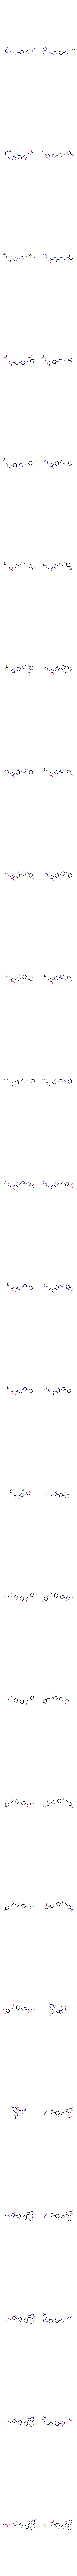

In [308]:
molecules = [mols for mols in df['standard_smiles']]
if None in molecules:
    print("yes")
img = Draw.MolsToGridImage(molecules, molsPerRow=2, subImgSize=(300, 800))

img

In [309]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to convert SMILES to Morgan fingerprints
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, radius=2, n_bits=2048):
        self.radius = radius
        self.n_bits = n_bits

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        fps = []
        for mol in X:
            #mol = Chem.MolFromSmiles(smi)
            if mol is None:
                # You can decide to handle invalid SMILES differently
                fps.append(np.zeros((self.n_bits,)))
            else:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.n_bits)
                arr = np.zeros((self.n_bits,), dtype=int)
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
        return np.array(fps)

# Load dataset
df = df

# Define pipeline
pipeline = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(radius=2, n_bits=2048)),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Split data
X = df['standard_smiles'].values
y = df['pic50'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate
y_pred = pipeline.predict(X_test)
print("Pipeline Test MSE:", mean_squared_error(y_test, y_pred))
print("Pipeline Test R²:", r2_score(y_test, y_pred))
y_pred = pipeline.predict(X_train)
print("Pipeline Train MSE:", mean_squared_error(y_train, y_pred))
print("Pipeline Train R²:", r2_score(y_train, y_pred))

Pipeline Test MSE: 1.1140089418702375
Pipeline Test R²: 0.7390445739697675
Pipeline Train MSE: 0.18528147734079875
Pipeline Train R²: 0.9426418196942594


r square with differnt random states is varying too much

In [310]:
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to convert SMILES (RDKit Mol objects) to Morgan fingerprints
class MorganFingerprintTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, radius=2, n_bits=2048):
        self.radius = radius
        self.n_bits = n_bits

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        fps = []
        for mol in X:
            # We assume that each entry in X is an RDKit Mol object.
            if mol is None:
                # Handle invalid entries by appending a zero vector.
                fps.append(np.zeros((self.n_bits,)))
            else:
                fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.n_bits)
                arr = np.zeros((self.n_bits,), dtype=int)
                DataStructs.ConvertToNumpyArray(fp, arr)
                fps.append(arr)
        return np.array(fps)

# Assume df is your DataFrame containing 'standard_smiles' (as RDKit Mol objects) and 'pic50'
# If you have SMILES strings, make sure to convert them to Mol objects first:
# df['standard_smiles'] = df['SMILE'].apply(Chem.MolFromSmiles)

# Define pipeline
pipeline = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(radius=2, n_bits=2048)),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Prepare data
X = df['standard_smiles'].values
y = df['pic50'].values

# Set up 5-fold cross-validation (each fold ~20% test split)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = []
fold = 1
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the pipeline on the current fold
    pipeline.fit(X_train, y_train)
    
    # Predict on the test set for this fold
    y_pred = pipeline.predict(X_test)
    
    # Compute R² score for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)
    print(f"Fold {fold} R²: {r2:.4f}")
    fold += 1

# Compute and print the average R² score across all folds
avg_r2 = np.mean(r2_scores)
print(f"\nAverage R² across all 5 folds: {avg_r2:.4f}")

Fold 1 R²: 0.6638
Fold 2 R²: 0.7612
Fold 3 R²: 0.4367
Fold 4 R²: 0.6395
Fold 5 R²: 0.6220

Average R² across all 5 folds: 0.6246


RandomForest R²: 0.7390445739697675
GradientBoosting R²: 0.7198636162950642
SVR R²: 0.6093561598388646
Ensemble R²: 0.7378043100034182


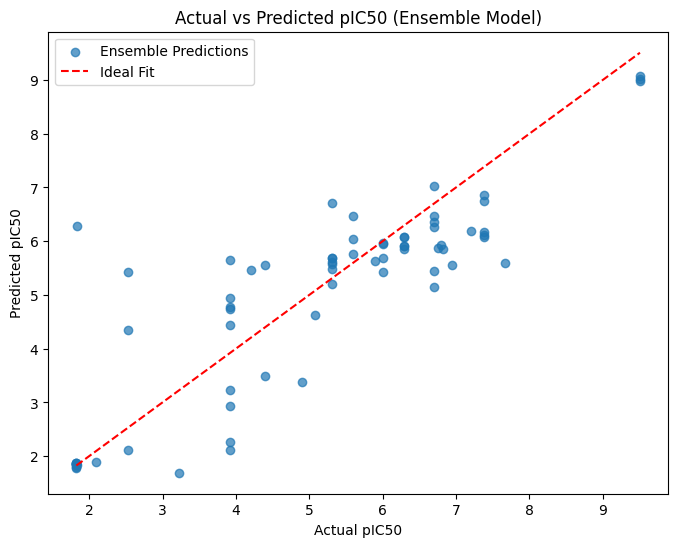

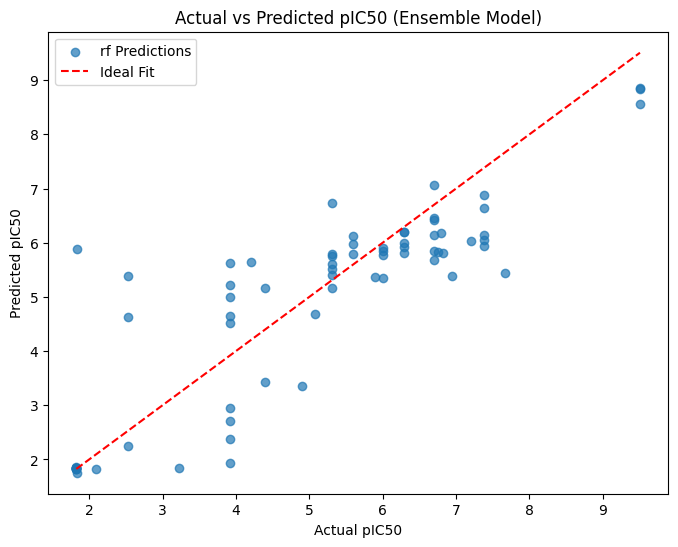

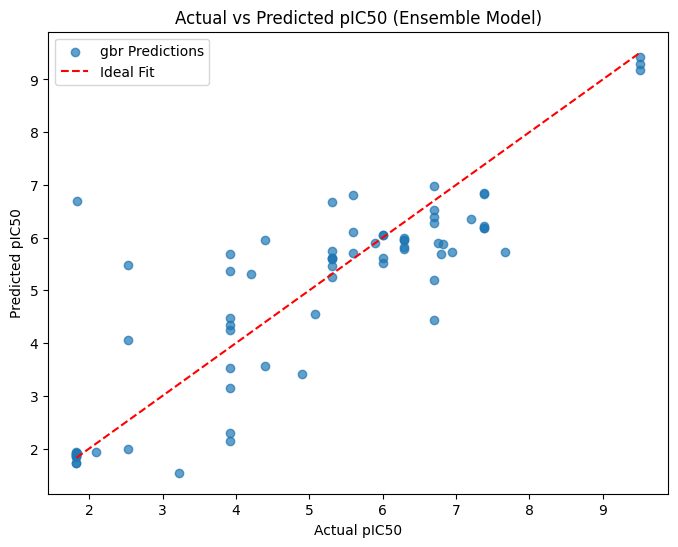

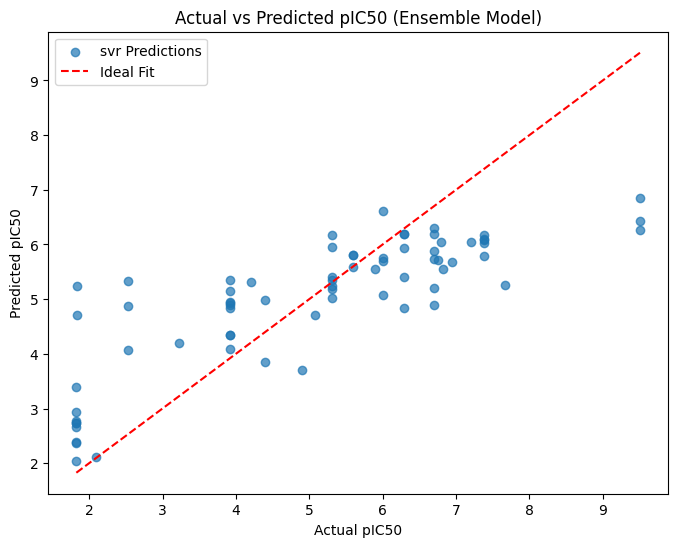

In [311]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt


X = df['standard_smiles'].values
y = df['pic50'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline for RandomForestRegressor
pipeline_rf = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(radius=2, n_bits=2048)),
    ('regressor', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Pipeline for GradientBoostingRegressor
pipeline_gbr = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(radius=2, n_bits=2048)),
    ('regressor', GradientBoostingRegressor(n_estimators=200, random_state=42))
])

# Pipeline for SVR (using scaling)
pipeline_svr = Pipeline([
    ('fingerprint', MorganFingerprintTransformer(radius=2, n_bits=2048)),
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Train the individual models
pipeline_rf.fit(X_train, y_train)
pipeline_gbr.fit(X_train, y_train)
pipeline_svr.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = pipeline_rf.predict(X_test)
y_pred_gbr = pipeline_gbr.predict(X_test)
y_pred_svr = pipeline_svr.predict(X_test)

# Calculate R² scores for individual models
r2_rf  = r2_score(y_test, y_pred_rf)
r2_gbr = r2_score(y_test, y_pred_gbr)
r2_svr = r2_score(y_test, y_pred_svr)

print("RandomForest R²:", r2_rf)
print("GradientBoosting R²:", r2_gbr)
print("SVR R²:", r2_svr)

# Create an ensemble prediction (simple average of predictions)
y_pred_ensemble = (y_pred_rf + y_pred_gbr ) / 2.0
r2_ensemble = r2_score(y_test, y_pred_ensemble)
print("Ensemble R²:", r2_ensemble)

# Optionally, plot actual vs. predicted for the ensemble model
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_ensemble, alpha=0.7, label='Ensemble Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs Predicted pIC50 (Ensemble Model)')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7, label='rf Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs Predicted pIC50 (Ensemble Model)')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_gbr, alpha=0.7, label='gbr Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs Predicted pIC50 (Ensemble Model)')
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_svr, alpha=0.7, label='svr Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Fit')
plt.xlabel('Actual pIC50')
plt.ylabel('Predicted pIC50')
plt.title('Actual vs Predicted pIC50 (Ensemble Model)')
plt.legend()
plt.show()

In [312]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

# Train the individual pipelines on the entire dataset
X = df['standard_smiles'].values
y = df['pic50'].values

pipeline_rf.fit(X, y)
pipeline_gbr.fit(X, y)
# If you need SVR, you can also train it:
pipeline_svr.fit(X, y)

# Define a custom ensemble regressor that averages predictions from the given models
class EnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, estimators=None, weights=None):
        """
        Parameters:
            estimators (list of tuples): List of (name, estimator) tuples.
            weights (list, optional): Weights to use for averaging predictions.
                                      If None, simple mean is used.
        """
        self.estimators = estimators if estimators is not None else []
        self.weights = weights

    def fit(self, X, y):
        # Fit each estimator on the entire dataset
        for name, est in self.estimators:
            est.fit(X, y)
        return self

    def predict(self, X):
        # Collect predictions from each estimator
        preds = np.array([est.predict(X) for name, est in self.estimators])
        # Average the predictions; if weights are provided, use them
        if self.weights is None:
            return preds.mean(axis=0)
        else:
            return np.average(preds, axis=0, weights=self.weights)

# Create the final ensemble model using the trained pipelines for RF and GBR
final_pic50_model = EnsembleRegressor(estimators=[('rf', pipeline_rf), ('gbr', pipeline_gbr), ('svr', pipeline_svr)])

# Now final_model is trained on the whole dataset.
# Example: Predict on new data (new_X should be an array of SMILES strings)
# new_predictions = final_model.predict(new_X)


In [313]:
X = df['standard_smiles'].values
y = df['pic50'].values
final_pic50_model.fit(X, y)


EnsembleRegressor(estimators=[('rf',
                               Pipeline(steps=[('fingerprint',
                                                MorganFingerprintTransformer()),
                                               ('regressor',
                                                RandomForestRegressor(n_estimators=200,
                                                                      random_state=42))])),
                              ('gbr',
                               Pipeline(steps=[('fingerprint',
                                                MorganFingerprintTransformer()),
                                               ('regressor',
                                                GradientBoostingRegressor(n_estimators=200,
                                                                          random_state=42))])),
                              ('svr',
                               Pipeline(steps=[('fingerprint',
                                                MorganFingerprintTransformer()),
                                               ('scaler', StandardScaler()),
                                               ('svr', SVR())]))])

In [314]:
X

array([<rdkit.Chem.rdchem.Mol object at 0x0000018D071E8660>,
       <rdkit.Chem.rdchem.Mol object at 0x0000018D03060190>], dtype=object)

In [315]:
y_pred= final_pic50_model.predict(X)
r2_score(y_pred, y)

0.9142749926798944

In [316]:
'''import chemprop
arguments = [
      '--test_path', '/dev/null',
      '--preds_path', '/dev/null',
      '--checkpoint_dir', 'chemprop_checkpoint'
  ]

args = chemprop.args.PredictArgs().parse_args(arguments)

model_objects = chemprop.train.load_model(args=args)'''

"import chemprop\narguments = [\n      '--test_path', '/dev/null',\n      '--preds_path', '/dev/null',\n      '--checkpoint_dir', 'chemprop_checkpoint'\n  ]\n\nargs = chemprop.args.PredictArgs().parse_args(arguments)\n\nmodel_objects = chemprop.train.load_model(args=args)"

In [317]:
fps = [FingerprintMols.FingerprintMol(Chem.MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128) for x in df['SMILE'][:30]]

def reward(mol):
  fp = FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               minSize=128)

  s = DataStructs.BulkTanimotoSimilarity(fp,fps)

  return (np.dot(np.array(s),np.array(df['REWARD'][:30]))/len(s))#*(np.exp(1/sascorer.calculateScore(mol)))

score_limit = 4.0
def reward_with_score(mol, pic50_model = None):
  #fp = FingerprintMols.FingerprintMol(mol, minPath=1, maxPath=7, fpSize=2048,
                               #bitsPerHash=2, useHs=True, tgtDensity=0.0,
                               #minSize=128)

  #s = DataStructs.BulkTanimotoSimilarity(fp,fps)
  smile = Chem.MolToSmiles(mol)
  
  '''smiles = [[smile]]
  preds = chemprop.train.make_predictions(args=args, smiles=smiles, model_objects=model_objects)
  pic50=preds[0][0]'''

  standard_mol = standardize_smiles(smile)
  y_pred= pic50_model.predict([standard_mol])
  print("pic 50 pred", y_pred)
  pic50 = y_pred[0]


  print("mic estimate",pic50)
  '''
  df = pd.DataFrame({'SMILES': [smile]})
  df.to_csv('input.csv', index=False)

  # Specify the path to the trained model
  model_path = 'chemprop_model_pca.pt'  # Update this path to your model file
  
  # Run chemprop predict using command line
  os.system(f"chemprop_predict --test_path input.csv --checkpoint_path {model_path} --preds_path chemprop_predictions.csv")

  # Read and display results
  if os.path.exists('chemprop_predictions.csv'):
      predictions = pd.read_csv('chemprop_predictions.csv') 
      print("\nResults:")
      print(predictions)
      print(predictions['pIC50'][0])
  else:
      print("Prediction failed to generate output file")
  mic_estimate = predictions['pIC50'][0]
  prim_reward = mic_estimate
  print("mic estimate",mic_estimate)'''
  sa_score = sascorer.calculateScore(mol)
  qed_score = QED.qed(mol)
  #prim_reward = (20*pic50*qed_score*2.5)/(0.5*sa_score)
  #prim_reward = (15*pic50) + (20 * qed_score) - (5 *sa_score)
  prim_reward = (15*pic50)
  print("primary reward," , prim_reward)
  #print("sa_score," , sa_score)

  #wt = Descriptors.MolWt(mol)
  
  #temp = np.exp((-1*sa_score))*100                                #removed the score limit on the sa csore as it didnt make much sense
  #print("sa factor ," , temp)
  #prim_reward *= temp
  #sa_score = 1
  #print("primary reward wuth sa score," , prim_reward)
  # if(sa_score < score_limit):
  #   score_limit = sa_score
  #temp = np.exp((abs(wt - 600)*-1)/(100))*0.01                   #the weight factor was disproportionately changing the reward function,(on a magnitude of 62 orders!!) so scaled it appropriately. 
  #print("weigt factor," , temp)
  #prim_reward *= temp
  #print("primary reward with wweigt and sa sccroe," , prim_reward)
  #print("log reward", np.log(prim_reward))
  #print("_________________________________________________________________________________________________________________")
  return prim_reward, pic50, sa_score, qed_score
  # return (np.dot(np.array(s),np.array(df['REWARD'][:30]))/len(s))*(np.exp(1/sascorer.calculateScore(mol)))

changes since 25 oct   
1)removed the score limit on the sa csore as it didnt make much sense   
2)the weight factor was disproportionately changing the reward function,(on a magnitude of 62 orders!!) so scaled it appropriately.

In [318]:
import time

In [319]:
for i in range(5):
    start = time.time()
    print("molecule number, ", i)
    reward_with_score(Chem.MolFromSmiles(df['SMILE'].iloc[i]), final_pic50_model)
    print("actual score: ", df['pic50'].iloc[i] )
    end = time.time()
    print("time taken for prediction of one molecule",end-start)

molecule number,  0
pic 50 pred [4.17561908]
mic estimate 4.175619077153953
primary reward, 62.63428615730929
actual score:  3.697414907005954
time taken for prediction of one molecule 0.01824188232421875
molecule number,  1
pic 50 pred [5.86413368]
mic estimate 5.864133684773247
primary reward, 87.9620052715987
actual score:  6.0
time taken for prediction of one molecule 0.01912975311279297
molecule number,  2
pic 50 pred [5.91723344]
mic estimate 5.9172334406659415
primary reward, 88.75850160998912
actual score:  6.0
time taken for prediction of one molecule 0.012257814407348633
molecule number,  3
pic 50 pred [6.85603046]
mic estimate 6.856030457972167
primary reward, 102.84045686958251
actual score:  7.386294361119891
time taken for prediction of one molecule 0.021061182022094727
molecule number,  4
pic 50 pred [6.51131035]
mic estimate 6.511310351875214
primary reward, 97.66965527812822
actual score:  7.386294361119891
time taken for prediction of one molecule 0.013816118240356445

In [320]:
reward(Chem.MolFromSmiles(df['SMILE'].iloc[0]))

0.7337891258513708

In [321]:
final_frags = []
atch_idx = []
idx = -1

In [322]:
idx -= 1

Compound Number: -1


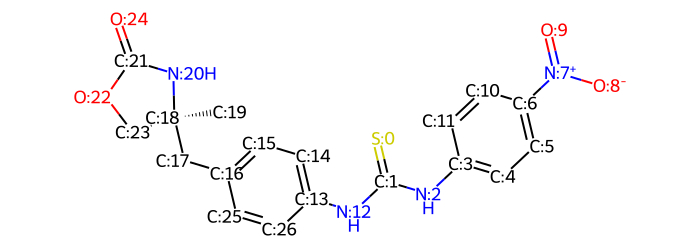

In [323]:
idx += 1
print("Compound Number:",idx)
mol2 = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
mol = Chem.MolFromSmiles(df['SMILE'].iloc[idx])
Chem.Draw.MolsToGridImage([number_atoms(mol2)],subImgSize = (700,250),molsPerRow = 1)

In [324]:
break_idx = [(19,20)] #the indices about which fragmentation should take place

In [325]:
mh = Chem.RWMol(Chem.AddHs(mol))
for x in break_idx:
  a1idx = x[0]
  a2idx = x[1]
  Chem.Kekulize(mh,clearAromaticFlags=True)
  mh.RemoveBond(a1idx,a2idx) #Removing those respective bonds
  # print(Chem.MolToSmiles(mh))

In [326]:
#After the frags have been split, there is a '.' between each of their smiles representation
frags = [Chem.MolFromSmiles(x) for x in Chem.MolToSmiles(mh).split('.')]
curr_frags = []
for x in frags:
  sm = Chem.MolToSmiles(x)
  if(sm not in final_frags):
    final_frags.append(sm)
    curr_frags.append(sm)
  else:
    pass
    # frags.remove(x)
try:
  im = Chem.Draw.MolsToGridImage(list(map(lambda x:number_atoms(Chem.MolFromSmiles(x)),curr_frags)),molsPerRow = 3,subImgSize = (300,300))
except:
  im = None
  print("Nothing to add")

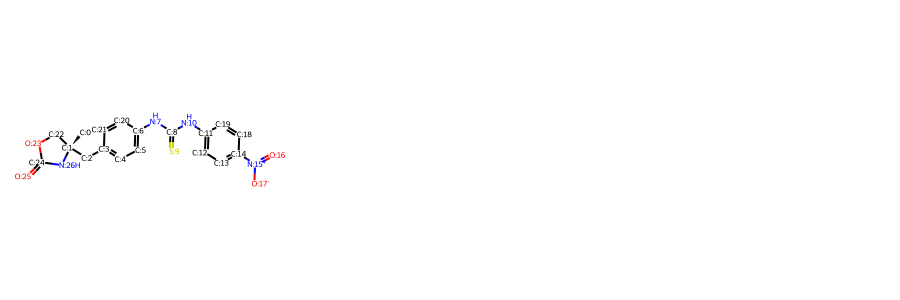

In [327]:
im

In [328]:
final_frags.pop(-1)

'C[C@]1(Cc2ccc(NC(=S)Nc3ccc([N+](=O)[O-])cc3)cc2)COC(=O)N1'

In [329]:
at_idx = [[5]]
for i in at_idx:
  atch_idx.append(i)
len(final_frags),len(atch_idx)

(0, 1)

In [330]:
'''valid_frags = [mol for mol in map(Chem.MolFromSmiles, final_frags) if mol is not None]

# Attempt to draw the valid molecules
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(valid_frags, molsPerRow=3, subImgSize=(300, 300))
img.show()'''

'valid_frags = [mol for mol in map(Chem.MolFromSmiles, final_frags) if mol is not None]\n\n# Attempt to draw the valid molecules\nfrom rdkit.Chem import Draw\nimg = Draw.MolsToGridImage(valid_frags, molsPerRow=3, subImgSize=(300, 300))\nimg.show()'

In [331]:
#Chem.Draw.MolsToGridImage(list(map(Chem.MolFromSmiles,final_frags)))

In [332]:
frags_list = [(x,y) for x,y in zip(final_frags,atch_idx)]

In [333]:
frags_list = [('C=O', [0]),
 ('F', [0]),
 ('C', [0, 0]),
 ('c1ccccc1', [0, 1, 3]),
 ('c1c[nH]cn1', [0, 1, 3]),
 ('O=C1NCCO1', [2, 4]),
 ('C=N', [0, 1]),
 ('N', [0, 0, 0]),
 ('C1CNCCN1', [0, 1, 2, 5]),
 ('O=[N+][O-]', [1]),
 ('c1ccoc1', [2, 4]),
 ('c1ccsc1', [2, 4]),
 ('Cl', [0]),
 ('O', [0, 0]),
 ('Br', [0]),
 ('c1cn[nH]c1', [3, 0]),
 ('c1ccncc1', [2, 4]),
 ('C1COCCN1', [5])]


df = pd.read_csv("big_fragments.csv")  # Replace with your file path
display(df)
big_frags = list(zip(df["Fragment_SMILES"], df["Attachment_Points"].apply(eval)))

print(big_frags)

bengio_frag = [
    ("Br", [0]),
    ("C", [0]),
    ("C#N", [0]),
    ("C1=CCCCC1", [0, 2, 3]),
    ("C1=CNC=CC1", [0, 2]),
    ("C1CC1", [0]),
    ("C1CCCC1", [0]),
    ("C1CCCCC1", [0, 1, 2, 3, 4, 5]),
    ("C1CCNC1", [0, 2, 3, 4]),
    ("C1CCNCC1", [0, 1, 3]),
    ("C1CCOC1", [0, 1, 2, 4]),
    ("C1CCOCC1", [0, 1, 2, 4, 5]),
    ("C1CNCCN1", [2, 5]),
    ("C1COCCN1", [5]),
    ("C1COCC[NH2+]1", [5]),
    ("C=C", [0, 1]),
    ("C=C(C)C", [0]),
    ("C=CC", [0, 1]),
    ("C=N", [0]),
    ("C=O", [0]),
    ("CC", [0, 1]),
    ("CC(C)C", [1]),
    ("CC(C)O", [1]),
    ("CC(N)=O", [2]),
    ("CC=O", [1]),
    ("CCC", [1]),
    ("CCO", [1]),
    ("CN", [0, 1]),
    ("CNC", [1]),
    ("CNC(C)=O", [0]),
    ("CNC=O", [0, 2]),
    ("CO", [0, 1]),
    ("CS", [0]),
    ("C[NH3+]", [0]),
    ("C[SH2+]", [1]),
    ("Cl", [0]),
    ("F", [0]),
    ("FC(F)F", [1]),
    ("I", [0]),
    ("N", [0]),
    ("N=CN", [1]),
    ("NC=O", [0, 1]),
    ("N[SH](=O)=O", [1]),
    ("O", [0]),
    ("O=CNO", [1]),
    ("O=CO", [1]),
    ("O=C[O-]", [1]),
    ("O=PO", [1]),
    ("O=P[O-]", [1]),
    ("O=S=O", [1]),
    ("O=[NH+][O-]", [1]),
    ("O=[PH](O)O", [1]),
    ("O=[PH]([O-])O", [1]),
    ("O=[SH](=O)O", [1]),
    ("O=[SH](=O)[O-]", [1]),
    ("O=c1[nH]cnc2[nH]cnc12", [3, 6]),
    ("O=c1[nH]cnc2c1NCCN2", [8, 3]),
    ("O=c1cc[nH]c(=O)[nH]1", [2, 4]),
    ("O=c1nc2[nH]c3ccccc3nc-2c(=O)[nH]1", [8, 4, 7]),
    ("O=c1nccc[nH]1", [3, 6]),
    ("S", [0]),
    ("c1cc[nH+]cc1", [1, 3]),
    ("c1cc[nH]c1", [0, 2]),
    ("c1ccc2[nH]ccc2c1", [6]),
    ("c1ccc2ccccc2c1", [0, 2]),
    ("c1ccccc1", [0, 1, 2, 3, 4, 5]),
    ("c1ccncc1", [0, 1, 2, 4, 5]),
    ("c1ccsc1", [2, 4]),
    ("c1cn[nH]c1", [0, 1, 3, 4]),
    ("c1cncnc1", [0, 1, 3, 5]),
    ("c1cscn1", [0, 3]),
    ("c1ncc2nc[nH]c2n1", [2, 6]),
]

other_frags = [
    ("CO", [1, 0]),
    ("O=c1[nH]cnc2[nH]cnc12", [3, 6]),
    ("S", [0, 0]),
    ("C1CNCCN1", [2, 5]),
    ("c1cc[nH+]cc1", [3, 1]),
    ("c1ccccc1", [0, 2]),
    ("C1CCCCC1", [0, 2]),
    ("CC(C)C", [1, 2]),
    ("C1CCOCC1", [0, 2]),
    ("c1cn[nH]c1", [4, 0]),
    ("C1CCNC1", [2, 0]),
    ("c1cncnc1", [0, 1]),
    ("O=c1nc2[nH]c3ccccc3nc-2c(=O)[nH]1", [8, 4]),
    ("c1ccncc1", [1, 0]),
    ("O=c1nccc[nH]1", [6, 3]),
    ("O=c1cc[nH]c(=O)[nH]1", [2, 4]),
    ("C1CCOC1", [2, 4]),
    ("C1CCNCC1", [1, 0]),
]

final_frags = frags_list #+ bengio_frag + other_frags
final_frags = bengio_frag
#final_frags = big_frags

Fragment_SMILES Attachment_Points
0                                      c1[nH]c(=O)nnc1C               [0]
1                                                 NC=NO               [0]
2                                             CCC(=O)NN               [0]
3     [C@]12N=C3Sc4ccc([N+](=O)[O-])cc4C(=O)N3[C@H](...           [0, 23]
4       N1C[C@@H](C)[C@H]Oc2cc(C#CC3CCCCC3)ccc2S1(=O)=O            [0, 3]
...                                                 ...               ...
6021                                    c1ccc2c(c1)OCO2         [0, 1, 4]
6022                                   N1CC(=O)NC(=O)C1               [0]
6023                                 c1ccc2ccc(Cl)cc2n1               [0]
6024                                  n1cnc2c(nnn2)c1=O                []
6025                 C1OC(=N)C[C@@]2(C(=O)Nc3ccccc32)C1        [0, 3, 14]

[6026 rows x 2 columns]

[('c1[nH]c(=O)nnc1C', [0]), ('NC=NO', [0]), ('CCC(=O)NN', [0]), ('[C@]12N=C3Sc4ccc([N+](=O)[O-])cc4C(=O)N3[C@H](c3ccccc3O1)[C@H]2', [0, 23]), ('N1C[C@@H](C)[C@H]Oc2cc(C#CC3CCCCC3)ccc2S1(=O)=O', [0, 3]), ('c1c(C)[nH]c(=O)[nH]c1=O', [0]), ('C(=O)n1c2ccccc2c2ccccc21', [0]), ('N1CCC2(CC1)CNC(=O)CO2', [0, 6]), ('N1C[C@H]2COC[C@@]2C1', [0, 5]), ('[C@@H]CC#C', [0, 0]), ('c1ccc(N=C(N)N=C(N)N)cc1', [0]), ('CN1C(=O)[C@@]2(O[C@@H][C@H]([Si](C)(C)c3ccccc3)[C@H]2C)c2ccccc21', [0, 5, 13, 20]), ('C1[C@@H]C[C@@]2(C)[C@H]1C[C@@H](O)[C@H]1[C@@]3(C)CC[C@@H](O)[C@@H](C)[C@H]3CC[C@@]12C', [0, 0]), ('C1CCC2C3CC(=O)C4CC(O)CCC4(C)C3CCC12C', [0]), ('c1cc(S(N)(=O)=O)ccc1O', [0]), ('c1c(C)c(O)c2ccccc2c1O', [0]), ('C(=O)CO', [0, 1, 1]), ('[C@H]1C[C@@](C)(O)[C@@H](O)[C@@H](C)O1', [0]), ('C1CSSCC2NC(=O)CNC(=O)CNC(=O)C3CSSCC(NC(=O)C(C)NC(=O)C4CCCN4C(=O)CNC(=O)C(CSSCC(N)C(=O)N3)NC2=O)C(=O)NCC(=O)NCC(=O)N1', [0, 8, 12, 37, 57]), ('C[C@H](O)CC(=O)O', [0]), ('N1CCCC1=O', [0, 1, 2]), ('c1c(C)n[nH]c1C', [0]), ('c1coc2cc3o

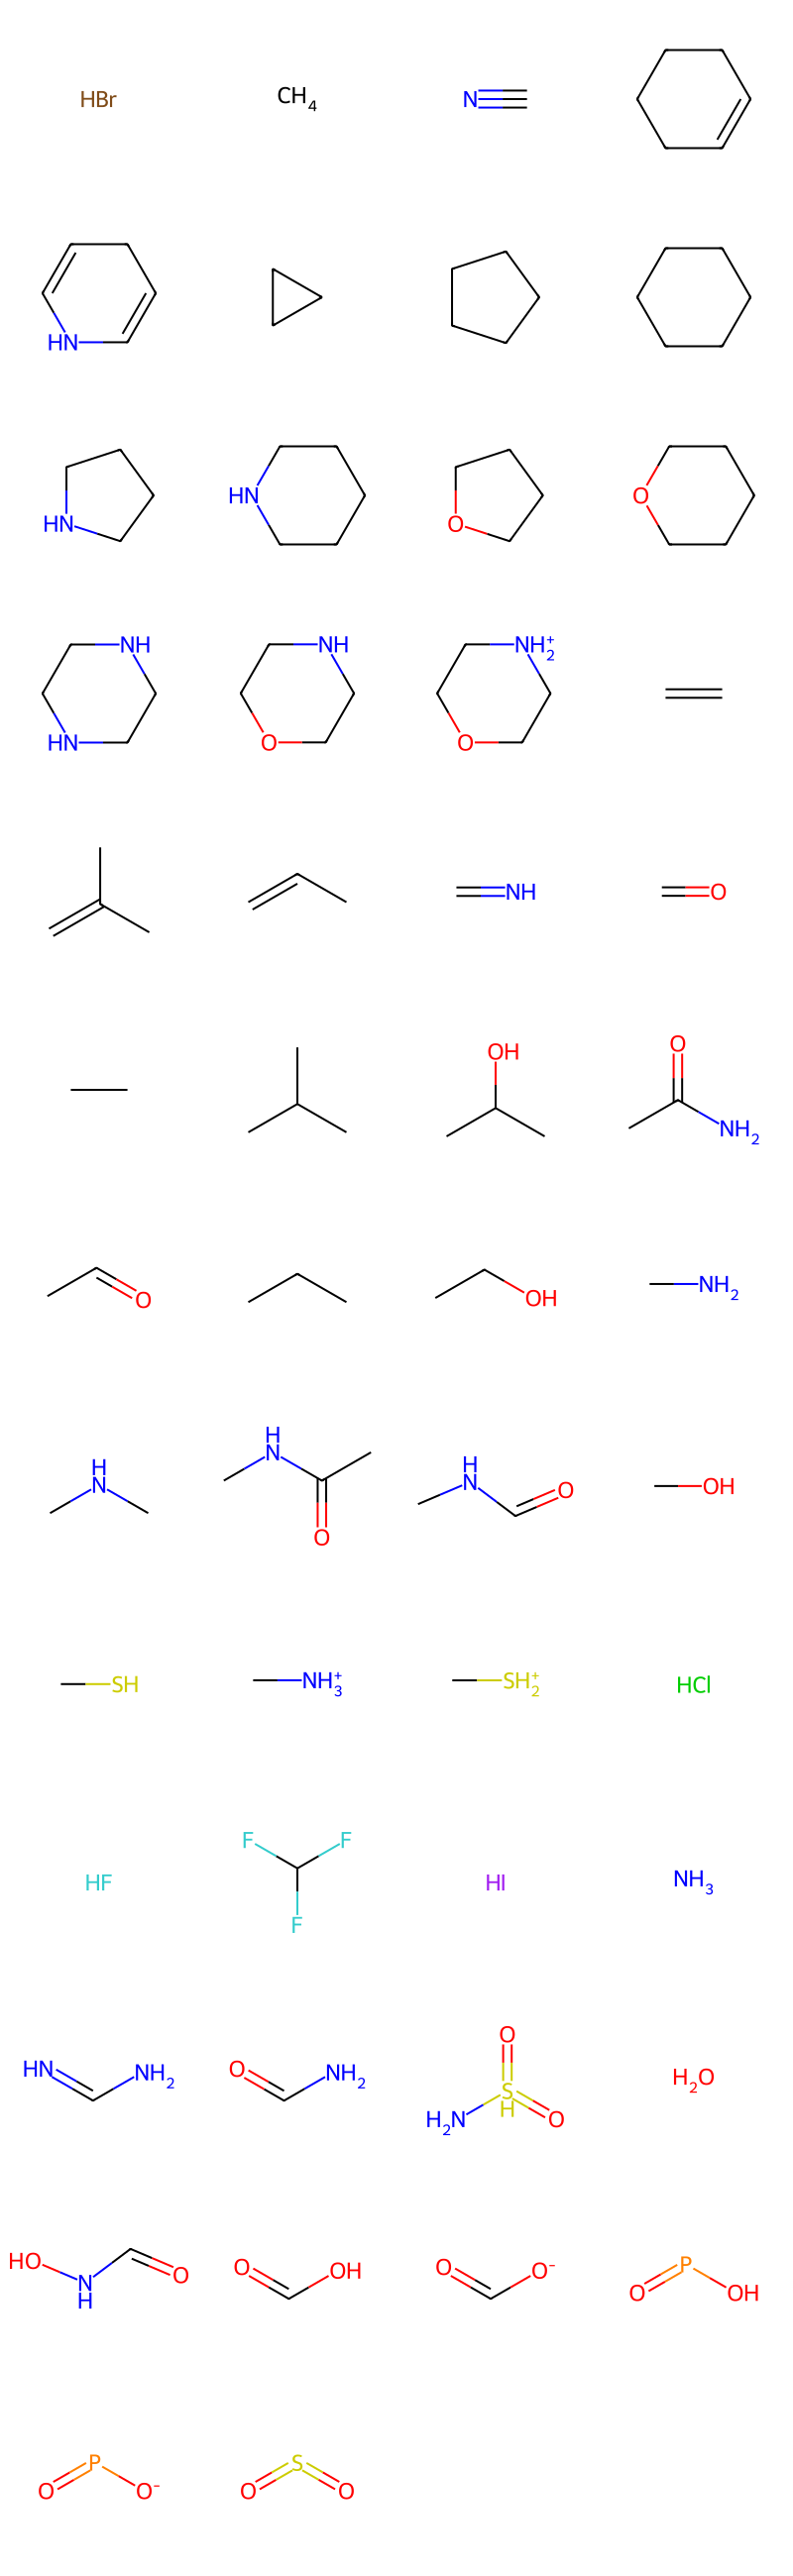

In [334]:
molecules = [Chem.MolFromSmiles(smiles) for smiles, _ in bengio_frag]

img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200))

img



In [335]:
import torch
from gflownet.config import init_empty, Config
from gflownet.models.graph_transformer import GraphTransformerGFN
from gflownet.envs.graph_building_env import GraphBuildingEnv
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext
from gflownet.envs.mol_building_env import MolBuildingEnvContext #Using this to build graphs didn't work
from gflownet.algo.trajectory_balance import TrajectoryBalance
from gflownet.algo.graph_sampling import GraphSampler

In [336]:
if torch.cuda.is_available():
    print("cuda available")
    from gflownet.utils.misc import set_main_process_device
    dev = torch.device('cuda')
    set_main_process_device(dev)
else:
    print("cpu mode")
    dev = torch.device('cpu')

cpu mode


In [337]:
torch.manual_seed(1)  # For demonstration purposes
cfg = Config()
env = GraphBuildingEnv()
ctx = FragMolBuildingEnvContext(fragments = final_frags)
model = GraphTransformerGFN(ctx, cfg).to(dev)
model2 = GraphTransformerGFN(ctx, cfg).to(dev)
# with open('/content/Without_SA') as file:
#   model = pickle.load(file)
# with open('/content/With_SA') as file:
#   model2 = pickle.load(file)
opt = torch.optim.Adam(model.parameters(), 3e-4)
algo = TrajectoryBalance(env, ctx, cfg)

In [338]:
model.parameters

<bound method Module.parameters of GraphTransformerGFN(
  (transf): GraphTransformer(
    (x2h): Sequential(
      (0): Linear(in_features=73, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (e2h): Sequential(
      (0): Linear(in_features=14, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (c2h): Sequential(
      (0): Linear(in_features=1, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
   

In [339]:
'''import logging
logger = logging.getLogger()
logger.filter()'''

'import logging\nlogger = logging.getLogger()\nlogger.filter()'

In [340]:
import pickle
import math

In [341]:
'''with open('D:\drug_modelling\Without_SA.unknown', 'rb') as file:
    model = pickle.load(file)
with open('D:\drug_modelling\With_SA','rb') as file:
    model2 = pickle.load(file)'''

"with open('D:\\drug_modelling\\Without_SA.unknown', 'rb') as file:\n    model = pickle.load(file)\nwith open('D:\\drug_modelling\\With_SA','rb') as file:\n    model2 = pickle.load(file)"

In [342]:
opt = torch.optim.Adam(model.parameters(), 1e-3) 
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses = [] 
avg_rewards = []
avg_sascore = []
avg_pic50 = []
avg_qed = []
record_dict = {}
epochs = 100
for i in tqdm(range(epochs)): 
    start = time.time()
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model2, 64)
        #print("traj len",len(trajs))
        objs = [ctx.graph_to_obj(i['result']) for i in trajs]
        full_reward_list =[]
        print("objs length ", len(objs))
        all_sa = []
        all_pic = []
        all_qed = []
        for x in objs:
            temp = reward_with_score(x, final_pic50_model)
            full_reward_list.append(temp[0])
            all_pic.append(temp[1])
            all_sa.append(temp[2])
            all_qed.append(temp[3])
            #print("primary reward", temp[0])
            print("pmic ", temp[1])
            print("sascore ", temp[2])
            print("qedscore ", temp[3])

        log_rewards = torch.tensor(full_reward_list).to(dev)
        avg_rewards.append((log_rewards / len(objs)).mean().item())
        avg_pic50.append(((torch.tensor(all_pic).to(dev)) / len(objs)).mean().item())
        avg_sascore.append(((torch.tensor(all_sa).to(dev)) / len(objs)).mean().item())
        avg_qed.append(((torch.tensor(all_qed).to(dev)) / len(objs)).mean().item())
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model2, batch)
    loss.backward()
    opt2.step()
    opt2.zero_grad()

    losses.append(loss.item())
    end = time.time()
    print(start-end)
    with torch.no_grad():
        if i %5 ==0:
            (gensmiles,genmoles,im) = test_model(model = model2,mols_per_row=2)
            record_dict[i] = (gensmiles,genmoles,im)
            with open("model2pic50_sascore_bengio_qed_frags_dict.pkl", "wb") as f:
                pickle.dump(record_dict, f)
            if i %10 ==0:
                checkpoint = {
                'epoch': i,
                'model_state_dict': model2.state_dict(),
                'optimizer_state_dict': opt2.state_dict(),
                'loss_history': losses,      
                'reward_history': avg_rewards,
                'pic50_history': avg_pic50,
                'sascore_history': avg_sascore,
                'qed_history': avg_qed,
                'record_dict':record_dict
                }
                torch.save(checkpoint, 'checkpoints/checkpoint_model2pic50_sascore_qed_bengio_frags_25epochs.pth')

  0%|          | 0/100 [00:00<?, ?it/s]

objs length  64
pic 50 pred [3.69718073]
mic estimate 3.697180731990103
primary reward, 55.45771097985155
pmic  3.697180731990103
sascore  3.2720234889790625
qedscore  0.5473417757869778
pic 50 pred [3.99729905]
mic estimate 3.9972990495181
primary reward, 59.9594857427715
pmic  3.9972990495181
sascore  2.3753591119652047
qedscore  0.6605886800689812
pic 50 pred [4.04707983]
mic estimate 4.04707983039149
primary reward, 60.70619745587235
pmic  4.04707983039149
sascore  4.256002837725319
qedscore  0.14027751084549975
pic 50 pred [3.67577417]
mic estimate 3.675774172976267
primary reward, 55.136612594644006
pmic  3.675774172976267
sascore  3.0856745361345173
qedscore  0.3105369591792739
pic 50 pred [4.10391441]
mic estimate 4.103914405783986
primary reward, 61.55871608675979
pmic  4.103914405783986
sascore  2.2447241610717104
qedscore  0.5719270675309555
pic 50 pred [3.66236421]
mic estimate 3.662364209227215
primary reward, 54.935463138408224
pmic  3.662364209227215
sascore  3.780889920

pic 50 pred [3.88393819]
mic estimate 3.883938193565912
primary reward, 58.25907290348868
pic 50 pred [4.44527861]
mic estimate 4.445278606660111
primary reward, 66.67917909990166
pic 50 pred [3.83434295]
mic estimate 3.834342952328473
primary reward, 57.515144284927096
pic 50 pred [4.06266661]
mic estimate 4.0626666062519545
primary reward, 60.93999909377932
pic 50 pred [3.77572765]
mic estimate 3.7757276493863174
primary reward, 56.63591474079476
pic 50 pred [4.25474143]
mic estimate 4.254741432883253
primary reward, 63.821121493248796
pic 50 pred [3.82532973]
mic estimate 3.8253297302715885
primary reward, 57.379945954073825
pic 50 pred [4.01104017]
mic estimate 4.011040167858397
primary reward, 60.16560251787595
pic 50 pred [4.32262198]
mic estimate 4.322621977909798
primary reward, 64.83932966864697
pic 50 pred [4.04412595]
mic estimate 4.044125952900434
primary reward, 60.66188929350651
pic 50 pred [4.67983722]
mic estimate 4.679837223622648
primary reward, 70.19755835433972
pic 

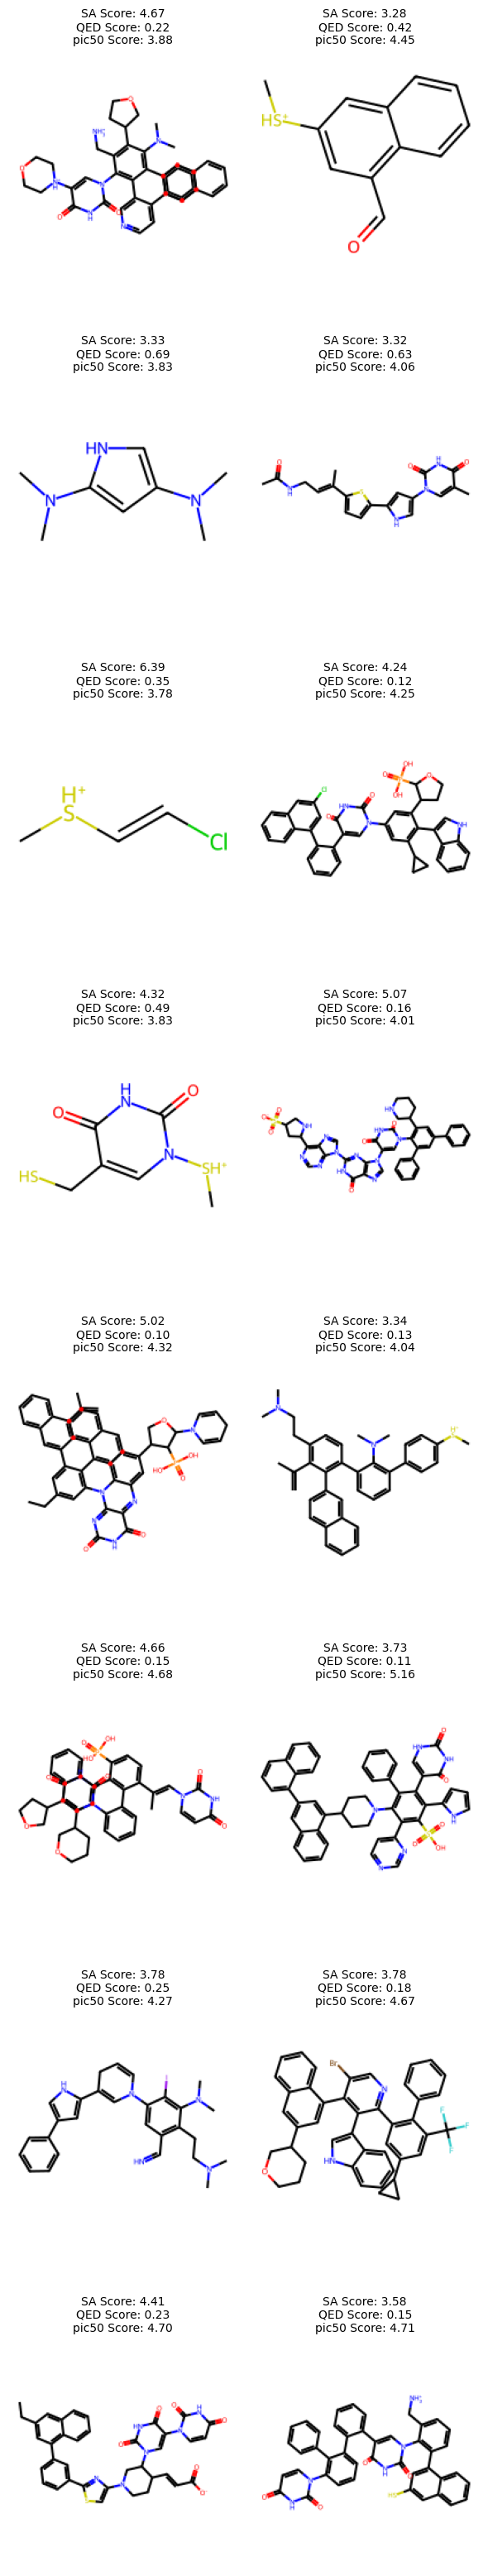

In [343]:

for i in record_dict:
    (gensmiles,genmoles,im) = record_dict[i]
(gensmiles,genmoles,im) = record_dict[60]
#print(gensmiles)
'''with open(".\generated\generated_molecules_pic50_sascore_bengio_frags_40epochs.txt", "w") as f:
    for smile in gensmiles:
        f.write(smile + "\n")
from rdkit.Chem import SDWriter

with SDWriter(".\generated\generated_molecules_pic50_sascore_bengio_frags_40epochs.sdf") as writer:
    for mol in genmoles:
        if mol is not None:  # Ensure molecule is valid
            writer.write(mol)

with open(".\generated\generated_molecules_pic50_sascore_bengio_frags_40epochs.png", "wb") as f:
    f.write(im.data)'''


from rdkit import Chem
from rdkit.Chem import QED
smiles_list = gensmiles
# Convert SMILES to molecule objects and calculate SA scores
molecules = []
sa_scores = []
qed_scores = []
pic_scores = []
for smiles in smiles_list:
    
    mol = Chem.MolFromSmiles(smiles)
    
    if mol:
        molecules.append(mol)
        temp = reward_with_score(mol, final_pic50_model)
        pic_score = temp[1]
        pic_scores.append(pic_score)
        sa_score = temp[2]
        sa_scores.append(sa_score)
        qed_score = temp[3]
        qed_scores.append(qed_score)
    else:
        print(f"Invalid SMILES: {smiles}")

import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Define grid size
mols_per_row = 2
sub_img_size = (200, 200)
n_rows = (len(molecules) + mols_per_row - 1) // mols_per_row

# Create a figure
fig, axes = plt.subplots(n_rows, mols_per_row, figsize=(mols_per_row * 3, n_rows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (mol, sa_score, qed_score, pic_score) in enumerate(zip(molecules, sa_scores, qed_scores, pic_scores)):
    # Draw molecule
    img = Draw.MolToImage(mol, size=sub_img_size)
    axes[i].imshow(img)
    axes[i].axis('off')
    # Display SA score
    axes[i].set_title(f'SA Score: {sa_score:.2f}\nQED Score: {qed_score:.2f}\npic50 Score: {pic_score:.2f}', fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#plt.savefig('D:\drug_modelling\generated\grid\generated_molecules_model2pic50_sascore_qed_bengio_frags_grid.png', dpi=400)
plt.show()


In [344]:
checkpoint = {
    'epoch': epochs,
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': opt2.state_dict(),
    'loss_history': losses,      
    'reward_history': avg_rewards,
    'pic50_history': avg_pic50,
    'sascore_history': avg_sascore, 
    'qed_history': avg_qed
}
#torch.save(checkpoint, 'checkpoints/checkpoint_pic50_sascore_qed_bengio_frags_70epochs.pth')

In [345]:
#torch.save(model2.state_dict(), 'saved_models/model_state_pic50_sascore_qed_bengio_frags_70epochs.pth')

In [346]:
#print(model2.state_dict())
#print(opt2.state_dict())

In [347]:
#checkpoint = torch.load('checkpoints/checkpoint_pic50_sascore_qed_bengio_frags.pth', map_location=torch.device('cpu'))
#model2.load_state_dict(checkpoint['model_state_dict'])
#opt2.load_state_dict(checkpoint['optimizer_state_dict'])
#loss_history = checkpoint.get('loss_history', [])
#reward_history = checkpoint.get('reward_history', [])

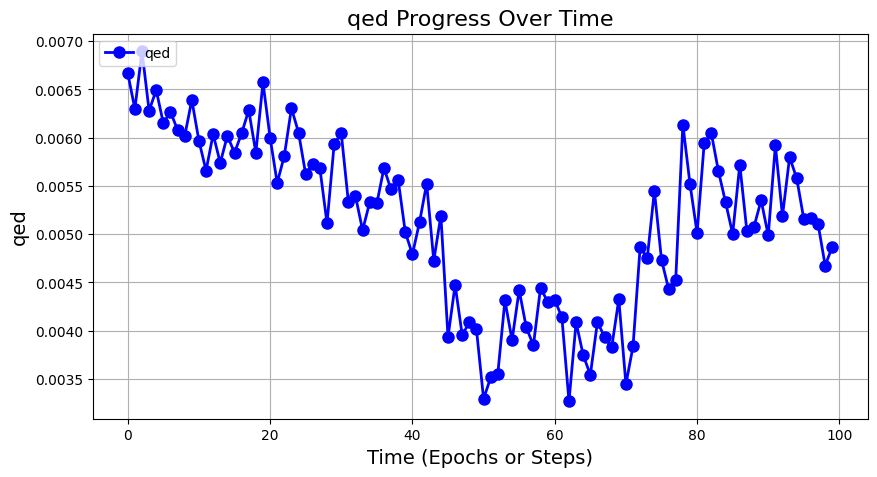

In [348]:
plt.figure(figsize=(10, 5))
plt.plot(avg_qed, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('qed', fontsize=14)
plt.title('qed Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['qed'], loc='upper left')

# Display the plot
plt.show()

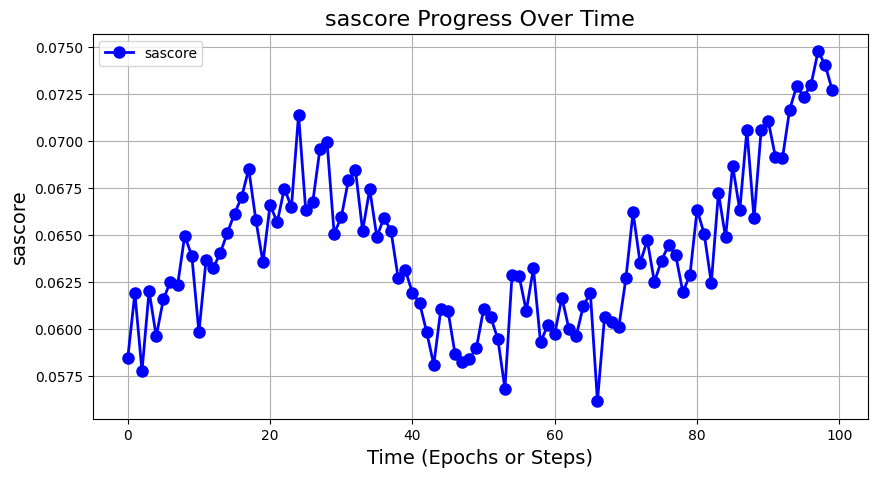

In [349]:
plt.figure(figsize=(10, 5))
plt.plot(avg_sascore, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('sascore', fontsize=14)
plt.title('sascore Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['sascore'], loc='upper left')

# Display the plot
plt.show()

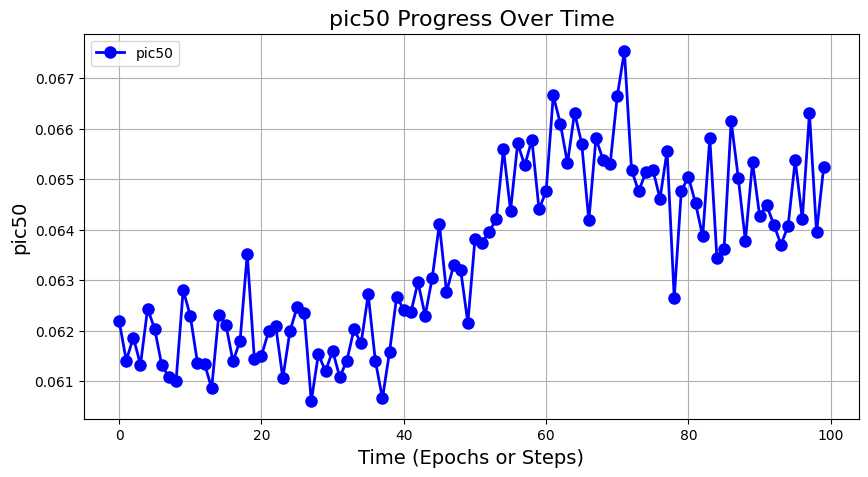

In [350]:
plt.figure(figsize=(10, 5))
plt.plot(avg_pic50, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('pic50', fontsize=14)
plt.title('pic50 Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['pic50'], loc='upper left')

# Display the plot
plt.show()

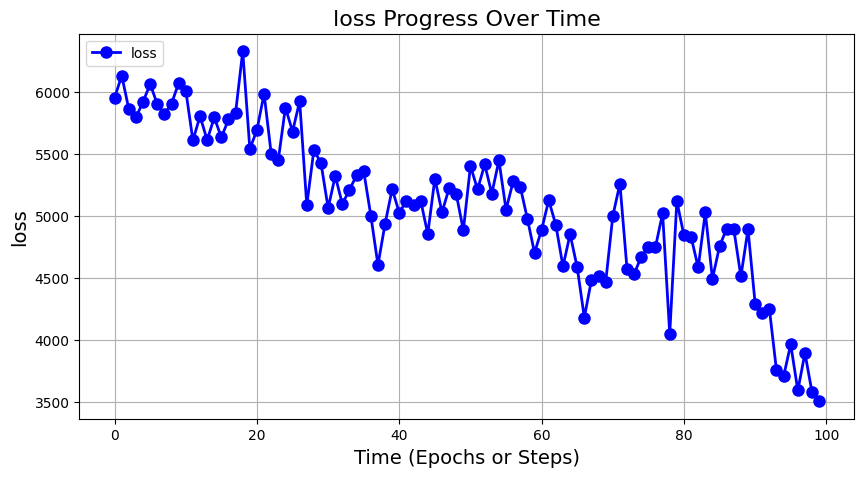

In [351]:
plt.figure(figsize=(10, 5))
plt.plot(losses, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('loss', fontsize=14)
plt.title('loss Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['loss'], loc='upper left')

# Display the plot
plt.show()

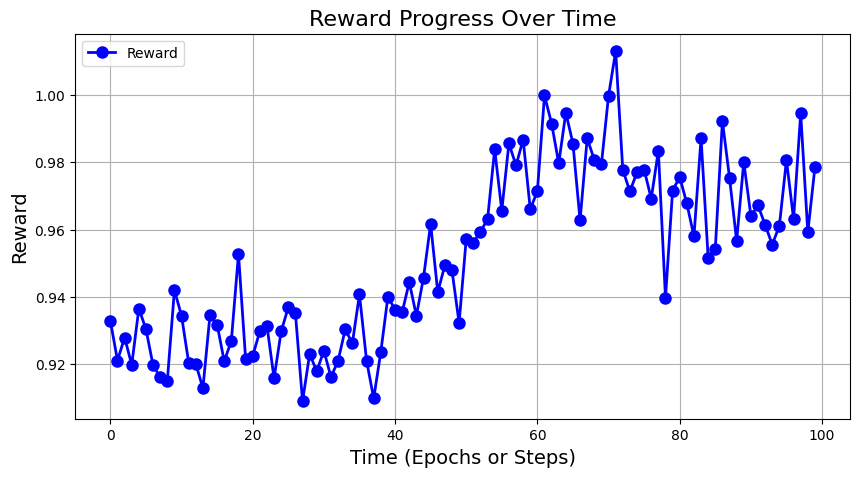

In [352]:
plt.figure(figsize=(10, 5))
plt.plot(avg_rewards, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)

# Adding labels and title
plt.xlabel('Time (Epochs or Steps)', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.title('Reward Progress Over Time', fontsize=16)

# Optional: Grid and legend
plt.grid(True)
plt.legend(['Reward'], loc='upper left')

# Display the plot
plt.show()

In [353]:
print(dssdf)

NameError: name 'dssdf' is not defined

In [ ]:
'''opt = torch.optim.Adam(model.parameters(), 1e-3)
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses2 = []
avg_rewards2 = []
for i in tqdm(range(150)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model2, 64)

        #objs = [ctx.graph_to_obj(i['result']) for i in trajs] gives problems with the bigger dataset

        objs = []
        valid_trajs=[]
        for traj in trajs:
            try:
                mol = ctx.graph_to_obj(traj['result'])
                Chem.SanitizeMol(mol)  # Validate the molecule
                objs.append(mol)
                valid_trajs.append(traj)
            except Chem.AtomValenceException:
                print(f"Valence issue in: {traj['result']}")
            except Chem.KekulizeException:
                print(f"Kekulization issue in: {traj['result']}")
            except Exception as e:
                print(f"Error: {e}")

        log_rewards = torch.tensor([reward_with_score(x)[0] for x in objs]).to(dev)
    avg_rewards2.append((log_rewards / beta).mean().item())
    trajs = valid_trajs
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model2, batch)
    loss.backward()
    opt2.step()
    opt2.zero_grad()

    losses2.append(loss.item())'''
    

'opt = torch.optim.Adam(model.parameters(), 1e-3)\nopt2 = torch.optim.Adam(model2.parameters(), 3e-4)\ntry:\n    from tqdm.notebook import tqdm\nexcept:\n    tdqm = lambda x: x\nbeta = 32\nlosses2 = []\navg_rewards2 = []\nfor i in tqdm(range(150)):\n    with torch.no_grad():  # We don\'t need to compute gradients here, they will be later\n        trajs = algo.create_training_data_from_own_samples(model2, 64)\n\n        #objs = [ctx.graph_to_obj(i[\'result\']) for i in trajs] gives problems with the bigger dataset\n\n        objs = []\n        valid_trajs=[]\n        for traj in trajs:\n            try:\n                mol = ctx.graph_to_obj(traj[\'result\'])\n                Chem.SanitizeMol(mol)  # Validate the molecule\n                objs.append(mol)\n                valid_trajs.append(traj)\n            except Chem.AtomValenceException:\n                print(f"Valence issue in: {traj[\'result\']}")\n            except Chem.KekulizeException:\n                print(f"Kekulization

In [ ]:
print(losses)

[3329.46630859375, 3281.767578125, 3159.0244140625, 3477.916259765625, 3714.6650390625, 3778.485595703125, 3926.273681640625, 3614.5146484375, 4151.5478515625, 5080.15185546875, 4697.0224609375, 6410.861328125, 4978.12353515625, 6382.69140625, 6337.36328125, 7192.6689453125, 7801.7734375, 8638.0498046875, 8266.4677734375, 7987.28076171875, 8697.1611328125, 8040.52001953125, 7904.87646484375, 8847.8544921875, 9670.6318359375]


In [ ]:
print(avg_rewards)

[0.6107423305511475, 0.5685449242591858, 0.6166825890541077, 0.6161495447158813, 0.6737870573997498, 0.7352697253227234, 0.7348300814628601, 0.7088750600814819, 0.776752769947052, 0.9200155735015869, 0.8558487892150879, 1.0440342426300049, 0.9407134652137756, 1.0848205089569092, 1.0930781364440918, 1.205769658088684, 1.2682921886444092, 1.3666563034057617, 1.3458809852600098, 1.3420848846435547, 1.4187647104263306, 1.3745450973510742, 1.3707319498062134, 1.4523473978042603, 1.520929217338562]


In [ ]:
'''opt = torch.optim.Adam(model.parameters(), 1e-3)
opt2 = torch.optim.Adam(model2.parameters(), 3e-4)
try:
    from tqdm.notebook import tqdm
except:
    tdqm = lambda x: x
beta = 32
losses2 = []
avg_rewards2 = []
for i in tqdm(range(500)):
    with torch.no_grad():  # We don't need to compute gradients here, they will be later
        trajs = algo.create_training_data_from_own_samples(model, 64)

        #objs = [ctx.graph_to_obj(i['result']) for i in trajs]

        objs = []
        valid_trajs=[]
        for traj in trajs:
            try:
                mol = ctx.graph_to_obj(traj['result'])
                Chem.SanitizeMol(mol)  # Validate the molecule
                objs.append(mol)
                valid_trajs.append(traj)
            except Chem.AtomValenceException:
                print(f"Valence issue in: {traj['result']}")
            except Chem.KekulizeException:
                print(f"Kekulization issue in: {traj['result']}")
            except Exception as e:
                print(f"Error: {e}")
        log_rewards = torch.tensor([reward(x) for x in objs]).to(dev)
    trajs = valid_trajs
    batch = algo.construct_batch(trajs, None, log_rewards).to(dev)
    loss, _ = algo.compute_batch_losses(model, batch)
    loss.backward()
    opt.step()
    opt.zero_grad()

    losses2.append(loss.item())
    avg_rewards2.append((log_rewards / beta).exp().mean().item())'''

'opt = torch.optim.Adam(model.parameters(), 1e-3)\nopt2 = torch.optim.Adam(model2.parameters(), 3e-4)\ntry:\n    from tqdm.notebook import tqdm\nexcept:\n    tdqm = lambda x: x\nbeta = 32\nlosses2 = []\navg_rewards2 = []\nfor i in tqdm(range(500)):\n    with torch.no_grad():  # We don\'t need to compute gradients here, they will be later\n        trajs = algo.create_training_data_from_own_samples(model, 64)\n\n        #objs = [ctx.graph_to_obj(i[\'result\']) for i in trajs]\n\n        objs = []\n        valid_trajs=[]\n        for traj in trajs:\n            try:\n                mol = ctx.graph_to_obj(traj[\'result\'])\n                Chem.SanitizeMol(mol)  # Validate the molecule\n                objs.append(mol)\n                valid_trajs.append(traj)\n            except Chem.AtomValenceException:\n                print(f"Valence issue in: {traj[\'result\']}")\n            except Chem.KekulizeException:\n                print(f"Kekulization issue in: {traj[\'result\']}")\n       

In [ ]:
#print(avg_rewards2)
#print(losses2)

1) reduce beta to low value while sampling.  

In [ ]:
'''for x in _:
  print(sascorer.calculateScore(x))'''

'for x in _:\n  print(sascorer.calculateScore(x))'

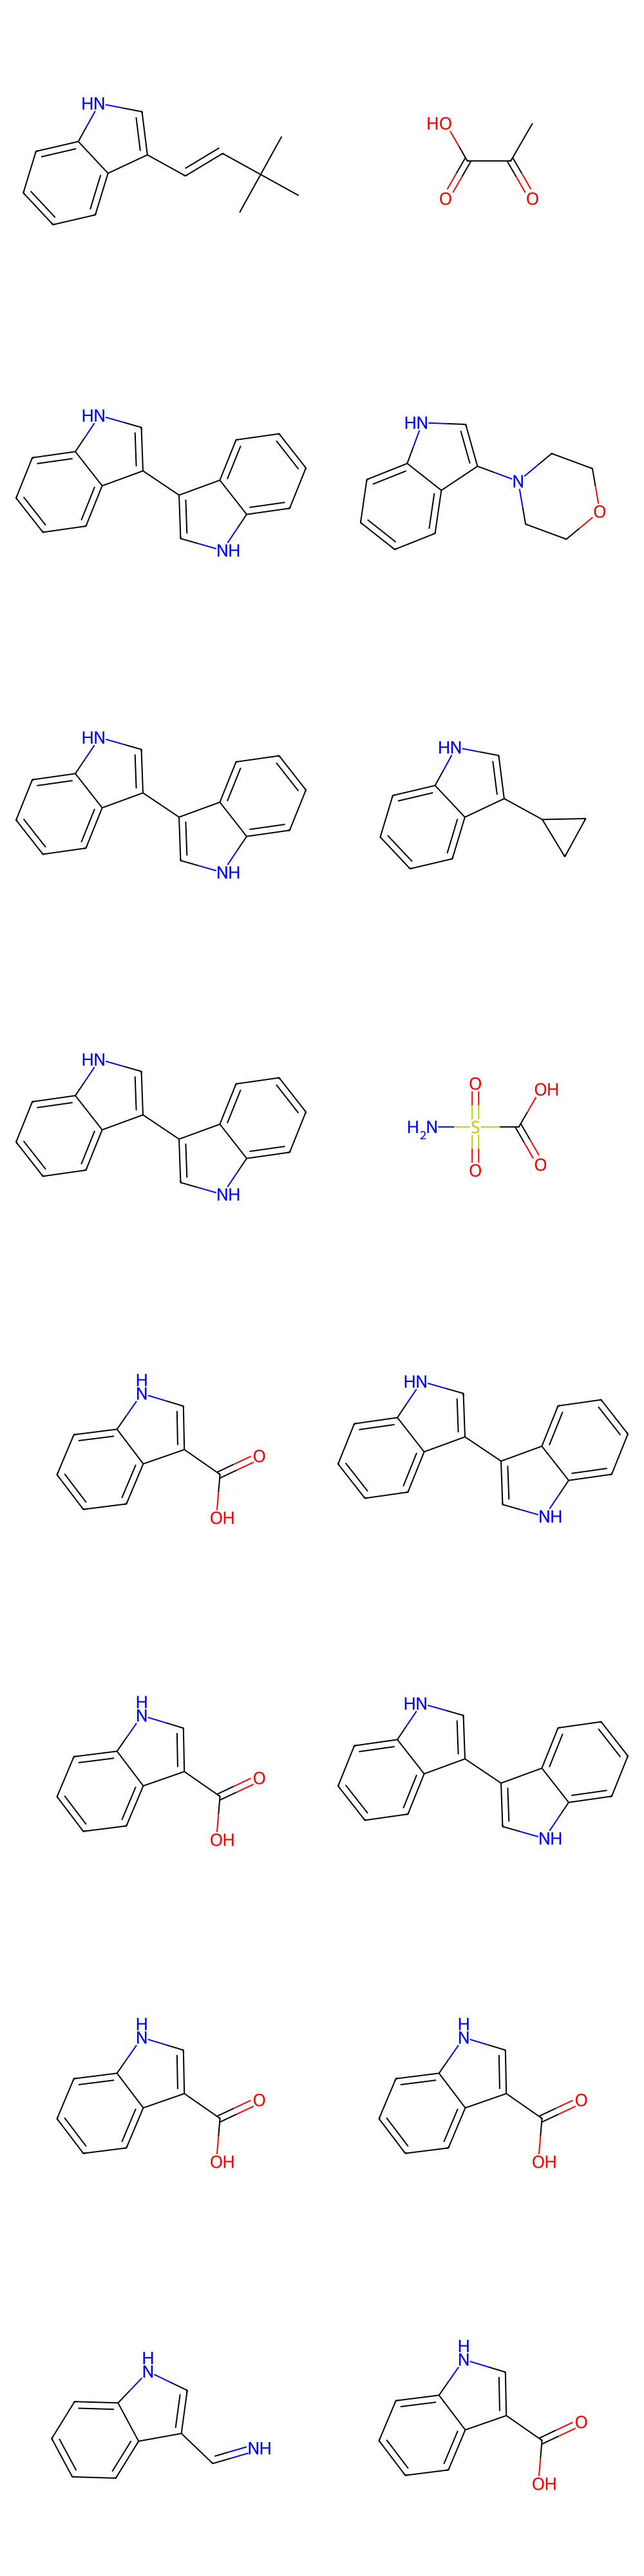

In [ ]:
gensmiles,genmoles,im = test_model(model = model2,mols_per_row=2)
im


molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A180>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 5.9479013110090655
primary reward, 89.42253123757433
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A1F0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.023909237519985
primary reward, 72.93148855009109
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A6C0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A5E0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833989
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A730>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A7A0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.273293214201253
primary reward, 114.60483474963425
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A810>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A880>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.109827018330062
primary reward, 49.76951264782609
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A8F0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A960>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677A9D0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AA40>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AAB0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AB20>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AB90>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.097909217936818
primary reward, 71.98121066464398
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AC00>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.87s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
average sa score 6.06732499132345
average weight 1.953949855379245
averge mic 0.5862605188913474


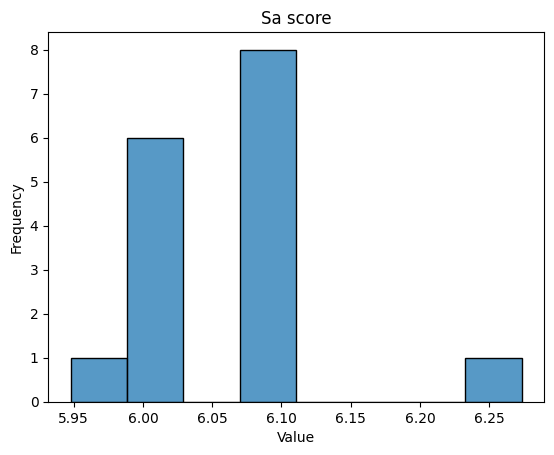

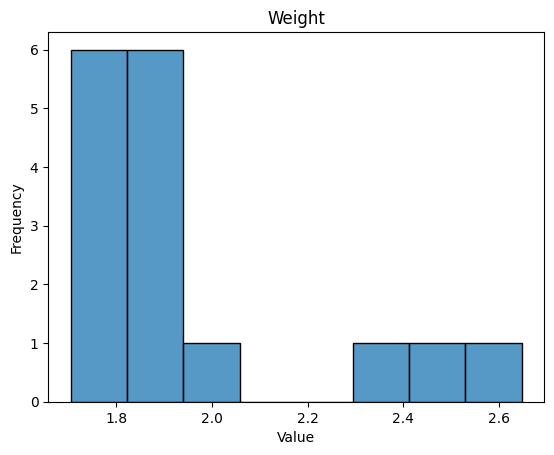

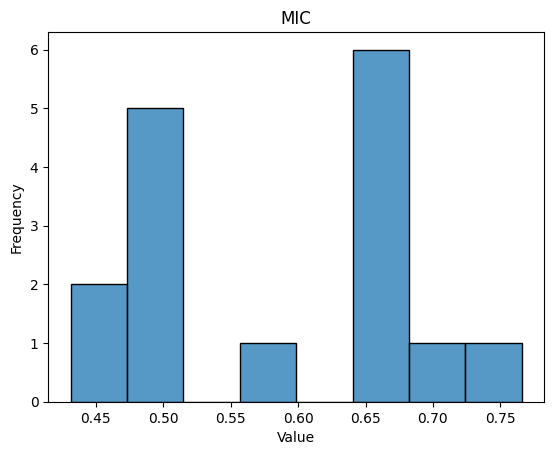

In [ ]:

avg_wt = []
avg_sa = []
avg_mic = []

for i in genmoles:
    print("molecule number, ", i)
    x = reward_with_score(i)
    avg_wt.append(x[2])
    avg_sa.append(x[1])
    avg_mic.append(x[3])
print("average sa score", np.average(avg_sa))
print("average weight", np.average(avg_wt))
print("averge mic", np.average(avg_mic))

sns.histplot(avg_sa, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Sa score')
plt.show()

sns.histplot(avg_wt, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Weight')
plt.show()

sns.histplot(avg_mic, bins=8, kde=False)  # kde=True adds a density curve
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('MIC')
plt.show()

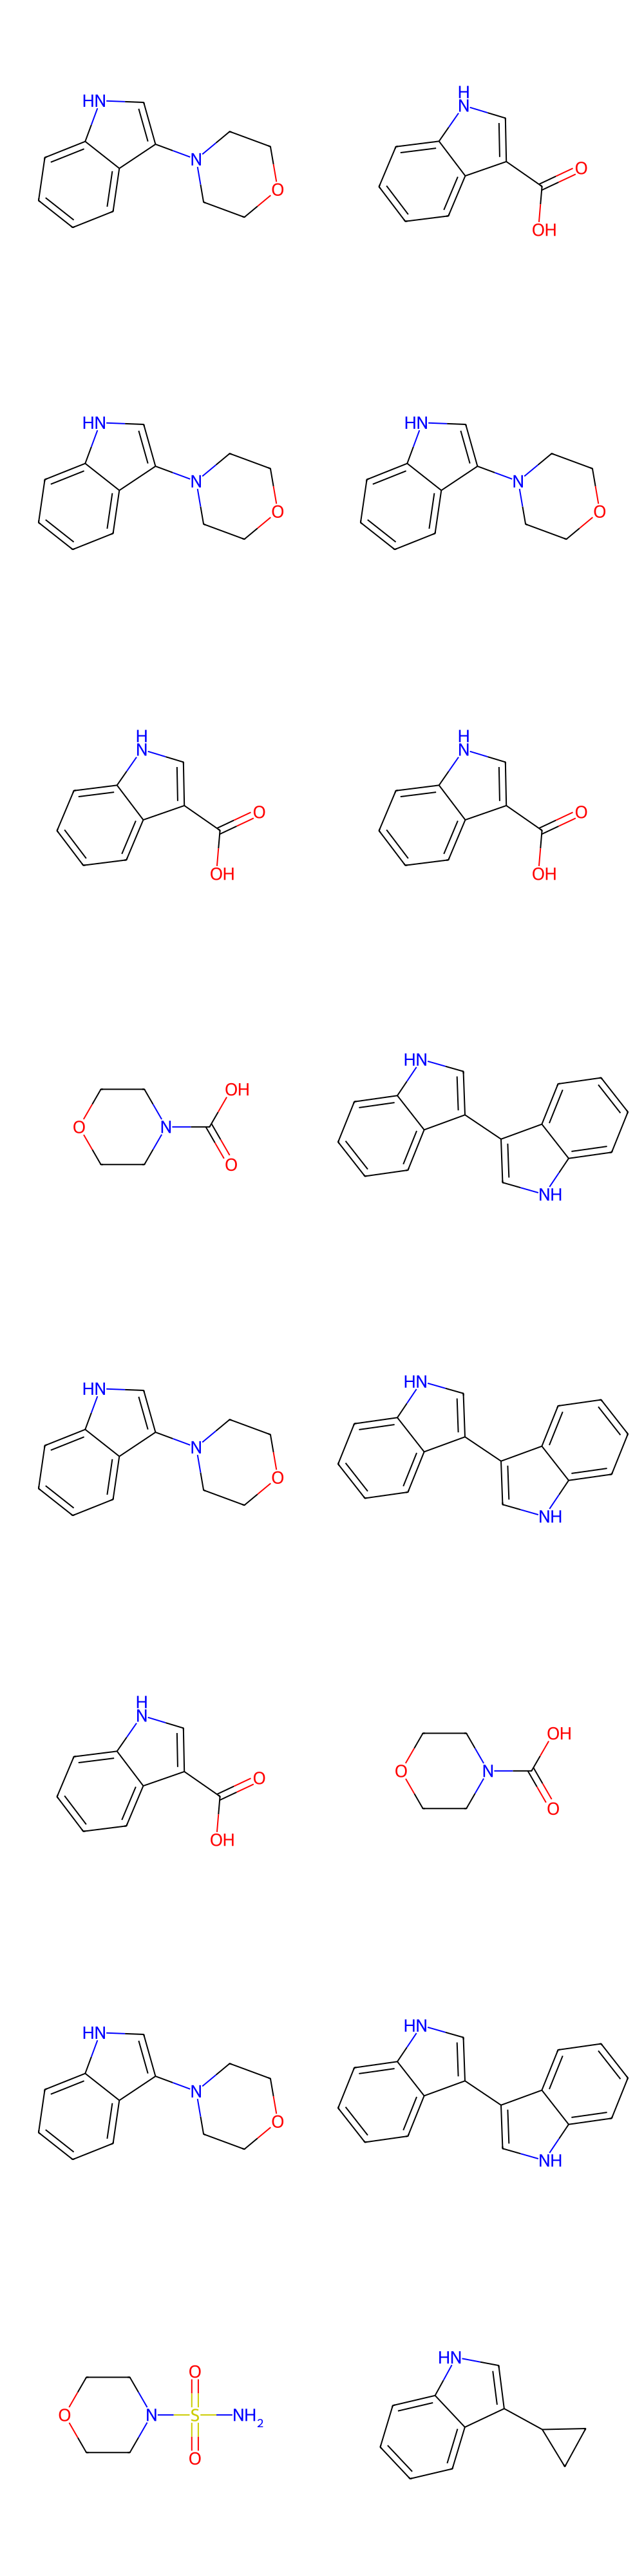

In [ ]:
gensmiles2,genmoles2,im2 = test_model(model = model2,mols_per_row=2)
im2


In [ ]:
for i in genmoles2:
    print("molecule number, ", i)
    reward_with_score(i)

molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B3E0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833988
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677ADC0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B4C0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833988
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B220>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833988
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B530>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AF10>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677AFF0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.007887947077809
primary reward, 80.29218773903487
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B5A0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B610>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833989
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B6F0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B760>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.002110161453331
primary reward, 118.0054005409327
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B7D0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.007887947077809
primary reward, 80.29218773903487
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B840>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.081848259722634
primary reward, 116.20546875833988
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B8B0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.106392159037747
primary reward, 77.34245959967332
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B920>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.018016196056402
primary reward, 69.93126307653763
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6C677B990>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.273293214201253
primary reward, 114.60483474963428


In [ ]:
from rdkit.Chem import SDMolSupplier

# Initialize an empty list to store the molecules
molecule_list = []

# Read the molecules from the SDF file
supplier = SDMolSupplier(".\\generated\\generated_molecules_small_frags_rachana_100epochs.sdf")

# Iterate through the molecules and add them to the list if they are valid
for mol in supplier:
    if mol is not None:  # Ensure molecule is valid
        molecule_list.append(mol)

# Check the first few molecules to confirm
print(f"Number of molecules read: {len(molecule_list)}")
print(molecule_list[:5])  # Display the first 5 molecules in the list


for i in molecule_list:
    print("molecule number, ", i)
    reward_with_score(i)


Number of molecules read: 16
[<rdkit.Chem.rdchem.Mol object at 0x000002C6D2694190>, <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694200>, <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694270>, <rdkit.Chem.rdchem.Mol object at 0x000002C6D26942E0>, <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694350>]
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694190>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.032121134947035
primary reward, 19.979737779577146
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694200>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.88s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.01023756150429
primary reward, 20.16363687827157
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694270>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.009105925037093
primary reward, 31.527117527389812
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26942E0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.003139334284321
primary reward, 75.05806842660584
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694350>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.018282622857521
primary reward, 8.491515989777126
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26943C0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.059708237547493
primary reward, 16.971055131856584
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694430>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.059620032191103
primary reward, 22.60794715216737
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26944A0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.075955070616924
primary reward, 24.81281052979111
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694510>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.86s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.010284656521648
primary reward, 19.950511085399466
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694580>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.019101471014898
primary reward, 16.38448943026697
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26945F0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.84s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.039075996959612
primary reward, 10.9563057946137
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694660>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.015600922260773
primary reward, 34.90370989538272
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26946D0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.013337454664464
primary reward, 10.974055564973613
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694740>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.07482008069861
primary reward, 12.185402446796681
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D26947B0>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.82s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.016473287868036
primary reward, 17.85624191494173
molecule number,  <rdkit.Chem.rdchem.Mol object at 0x000002C6D2694820>
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1


100%|██████████| 1/1 [00:03<00:00,  3.80s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:04
mic estimate 6.0091068889427
primary reward, 12.476045896748444


In [ ]:
# Read SMILES strings from a text file
with open('D:\drug_modelling\generated\generated_molecules_pic50_sascore_qed_bengio_frags_50epochs.txt', 'r') as file:
    smiles_list = [line.strip() for line in file if line.strip()]


In [ ]:
from rdkit import Chem
from rdkit.Chem import QED
smiles_list = gensmiles2
# Convert SMILES to molecule objects and calculate SA scores
molecules = []
sa_scores = []
qed_scores = []
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        molecules.append(mol)
        sa_score = sascorer.calculateScore(mol)
        sa_scores.append(sa_score)
        qed_score = QED.qed(mol)
        qed_scores.append(qed_score)
    else:
        print(f"Invalid SMILES: {smiles}")


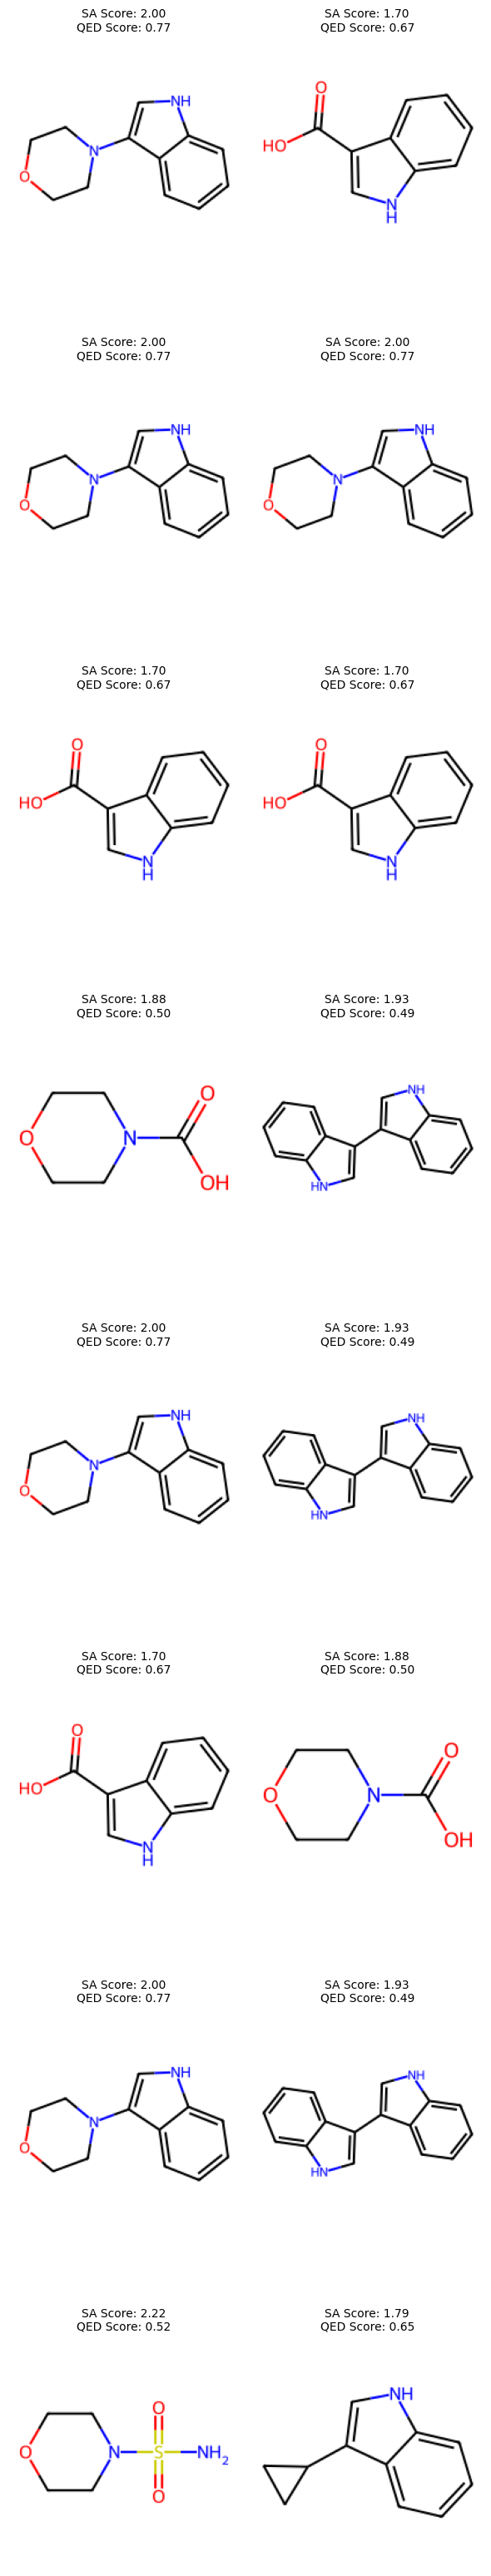

In [ ]:
import matplotlib.pyplot as plt
from rdkit.Chem import Draw

# Define grid size
mols_per_row = 2
sub_img_size = (200, 200)
n_rows = (len(molecules) + mols_per_row - 1) // mols_per_row

# Create a figure
fig, axes = plt.subplots(n_rows, mols_per_row, figsize=(mols_per_row * 3, n_rows * 4))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, (mol, sa_score, qed_score) in enumerate(zip(molecules, sa_scores, qed_scores)):
    # Draw molecule
    img = Draw.MolToImage(mol, size=sub_img_size)
    axes[i].imshow(img)
    axes[i].axis('off')
    # Display SA score
    axes[i].set_title(f'SA Score: {sa_score:.2f}\nQED Score: {qed_score:.2f}', fontsize=10)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#plt.savefig('D:\drug_modelling\generated\grid\generated_molecules_pic50_sascore_qed_bengio_frags_70epochs_grid.png', dpi=300)
plt.show()



In [ ]:
sdsf

In [ ]:
with open(".\generated\generated_smiles_pic50_sascore_qed_bengio_frags_70epochs.txt", "w") as f:
    for smile in gensmiles:
        f.write(smile + "\n")
from rdkit.Chem import SDWriter

with SDWriter(".\generated\generated_molecules_pic50_sascore_qed_bengio_frags_70epochs.sdf") as writer:
    for mol in genmoles:
        if mol is not None:  # Ensure molecule is valid
            writer.write(mol)

with open(".\generated\generated_molecules_pic50_sascore_qed_bengio_frags_70epochs.png", "wb") as f:
    f.write(im.data)

In [ ]:
with open(".\generated\generated_smiles2_pic50_sascore_qed_bengio_frags_70epochs.txt", "w") as f:
    for smile in gensmiles2:
        f.write(smile + "\n")
from rdkit.Chem import SDWriter

with SDWriter(".\generated\generated_molecules2_pic50_sascore_qed_bengio_frags_70epochs.sdf") as writer:
    for mol in genmoles2:
        if mol is not None:  # Ensure molecule is valid
            writer.write(mol)

with open(".\generated\generated_images2_pic50_sascore_qed_bengio_frags_70epochs.png", "wb") as f:
    f.write(im2.data)